In [2]:
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.svm import SVR
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from mpl_toolkits.mplot3d import axes3d 
import math
import networkx as nx
from sklearn.metrics import classification_report

%matplotlib inline


# Methods

In [3]:
class Candidate():
    def __init__(self, data, noise=True):
        self.data = data
        self.noise = noise

In [4]:
def detect_noise(graph, dict_frames):
    nodes = np.array(graph.nodes)
    for actual in nodes:
        for neighbor, weight in graph[actual].items():
            for neighbor_n, weight_n in graph[neighbor].items():
                (a,b,c) = calc_parabola_vertex(actual.data, neighbor.data, neighbor_n.data)
                if not np.isnan(a) and not np.isinf(a) and abs(a) != 0.0:
                    next_neighbors = dict((key,value) for key, value in dict_frames.items() if key > neighbor_n.data[2] and key < neighbor_n.data[2] + 10)
                    if (check_radius(a,b,c, next_neighbors, neighbor_n, neighbor, actual)):
                        actual.noise = False
                        neighbor.noise = False
                        neighbor_n.noise = False
    return nodes

In [5]:
def show_is_noise_before(dict_nodes):
    for index, node in dict_nodes.items():
        print(node.noise)
        
def show_is_noise_after(nodes):
    for node in nodes[:,4]:
        print(node.noise)

In [6]:
def check_parabola(a, b, c, node):
    y = a*node.data[0]**2 + b*node.data[0] + c
    delta = 5
    
    if(node.data[1] >= y - delta and node.data[1] <= y + delta):
        return True
    else:
        return False

In [7]:
def check_radius(a, b, c, next_neighbors, actual_node, before_node, b_before_node):
    is_parabola = {}
    for key, neighbors in next_neighbors.items():
        for neighbor in neighbors:
            if (check_parabola(a, b, c, neighbor)):
                if neighbor.data[2] in is_parabola:
                        predict = calc_predict_point(actual_node, before_node, b_before_node)
                        dist_r = calc_distance(predict,  is_parabola[neighbor.data[2]])
                        dist_n = calc_distance(predict, neighbor)
                        print(dist_r)
                        if dist_r > dist_n:
                            is_parabola[neighbor.data[2]] = neighbor
                else:
                     is_parabola[neighbor.data[2]] = neighbor

    if len(is_parabola.keys()) >= 1:
        for key, neighbor in is_parabola.items():
            neighbor.noise = False
        return True
    else:
        return False

In [8]:
def calc_parabola_vertex(first_point, second_point, third_point):
    denom = (first_point[0]-second_point[0]) * (first_point[0]-third_point[0]) * (second_point[0]-third_point[0]);
    a     = (third_point[0] * (second_point[1]-first_point[1]) + second_point[0] * (first_point[1]-third_point[1]) + first_point[0] * (third_point[1]-second_point[1])) / denom;
    b     = (third_point[0]*third_point[0] * (first_point[1]-second_point[1]) + second_point[0]*second_point[0] * (third_point[1]-first_point[1]) + first_point[0]*first_point[0] * (second_point[1]-third_point[1])) / denom;
    c     = (second_point[0] * third_point[0] * (second_point[0]-third_point[0]) * first_point[1]+third_point[0] * first_point[0] * (third_point[0]-first_point[0]) * second_point[1]+first_point[0] * second_point[0] * (first_point[0]-second_point[0]) * third_point[1]) / denom;

    return a,b,c

In [341]:
def detect_neighbor(position,item, data, graph):
    for index, candidate in data.items():
        distance =  calc_distance(item, candidate)
        if (distance <= 250) and ((candidate.data[2] >= item.data[2] + 1 and candidate.data[2] <= item.data[2] + 3)):
            graph.add_edge(item, candidate)

In [10]:
def create_graph(data):
    graph = nx.DiGraph()
    for index, item in data.items():
        detect_neighbor(index, item, data, graph)

    return graph

In [11]:
def calc_accelerate(actual_point, before_point, b_before_point):
    x_accelerate = ((actual_point.data[0] - before_point.data[0]) - (before_point.data[0] - b_before_point.data[0]))/(2.0**2)
    y_accelerate = ((actual_point.data[1] - before_point.data[1]) - (before_point.data[1] - b_before_point.data[1]))/(2.0**2)
    return (x_accelerate, y_accelerate)

In [12]:
def calc_velocity(actual_point, before_point, b_before_point, accelerate):
    x_velocity = (actual_point.data[0] - before_point.data[0])/2 + accelerate[0]*2.0
    y_velocity = (actual_point.data[1] - before_point.data[1])/2 + accelerate[1]*2.0
    return (x_velocity, y_velocity)

In [13]:
def calc_predict_point(actual_point, before_point, b_before_point):
    accelerate = calc_accelerate(actual_point, before_point, b_before_point) 
    velocity = calc_velocity(actual_point, before_point, b_before_point, accelerate)
    
    x_point = actual_point.data[0] + velocity[0]*2 + (accelerate[0]*(2.0**2))/2
    y_point = actual_point.data[1] + velocity[1]*2 + (accelerate[1]*(2.0**2))/2
    return Candidate([x_point, y_point])

In [14]:
def calc_angle(point_A, point_B_candidate, point_B_predict):
    m_first = (point_B_predict.data[1] - point_A.data[1])/(point_B_predict.data[0] - point_A.data[0])
    m_second = (point_B_candidate.data[1] - point_A.data[1])/(point_B_candidate.data[0] - point_A.data[0])
    angle = math.degrees(math.atan(abs((m_second - m_first)/(1 + m_first * m_second))))
    return angle

In [15]:
def calc_distance(itemA, itemB):
    return math.sqrt( (itemB.data[0] - itemA.data[0])**2 + (itemB.data[1] - itemB.data[1])**2 )

In [16]:
def calc_s(point_A, point_B_candidate, point_B_predict):
    d = abs(calc_distance(point_B_predict, point_B_candidate))
    dm = 0
    dM = 50
    angle = calc_angle(point_A, point_B_candidate, point_B_predict)

    s1 = np.log2((d-dm)/(dM-dm))
    s2 = np.log2(angle/180.0)
    return(s1, s2)

In [17]:
def create_dicts(array_candidate):
    dict_candidates = {}
    dict_frames = {}
    for index, data in enumerate(array_candidate):
        dict_candidates[index] = Candidate(data)
        if data[2] in dict_frames:
            dict_frames[data[2]].append(dict_candidates[index])
        else:
            dict_frames[data[2]] = [dict_candidates[index]]
    
    return (dict_candidates, dict_frames)

In [527]:
def create_final_nodes(graph, dict_frames):
    nodes = detect_noise(graph, dict_frames)

    filter_nodes = np.empty((0, 7))
    for node in nodes:
        if not node.noise:
            data = np.append(node.data, np.array([node.noise, node, None, None]))
            filter_nodes = np.append(filter_nodes, np.array([data]), axis=0)
    
    return filter_nodes

In [531]:
def separate_curves(nodes):
    curves = {}
    code = 0
    nodes_sort =  nodes[nodes[:,2].argsort()]

    for index, node in enumerate(nodes_sort):
        if node[2] > nodes_sort[index - 1][2] + 5 or index == 0:
            code += 1
            curves[code] = {}
            curves[code][node[2]] = [node]
        else:
            if node[2] in curves[code]:
                curves[code][node[2]].append(node)
            else:
                curves[code][node[2]] = [node]

    return curves

In [523]:
def define_direction(curves):
    anterior = (None, None)
   
    for index, dict_frames in curves.items():
        anterior = [None, None]
        for index_frame, list_frame in dict_frames.items():
            if len(list_frame) > 1:
                distance_min = None
                candidate = None
                for item in list_frame:
                    if (index_frame - 3 in dict_frames and index_frame - 2 in dict_frames and index_frame - 1 in dict_frames):
                        predict_left = calc_predict_point(
                            dict_frames[index_frame - 3][0][4], dict_frames[index_frame - 2][0][4], dict_frames[index_frame - 1][0][4])
                        distance_left = calc_distance(predict_left, item[4])
                    else:
                        distance_left = None

                    if (index_frame + 3 in dict_frames and index_frame + 2 in dict_frames and index_frame + 1 in dict_frames):
                        predict_right = calc_predict_point(
                            dict_frames[index_frame + 1][0][4], dict_frames[index_frame + 2][0][4], dict_frames[index_frame + 3][0][4])
                        distance_right = calc_distance(predict_right, item[4])
                    else:
                        distance_left = None

                    if distance_left is None and distance_right is None:
                        distance = None
                    elif distance_left is not None and distance_right is None:
                        distance = distance_left
                    elif distance_right is not None and distance_left is None:
                        distance = distance_right
                    else:
                        distance = (distance_left + distance_right)/2

                    if distance_min is None:
                        distance_min = distance
                        candidate = item
                    elif distance < distance_min:
                        distance_min = distance
                        candidate = item
                curves[index][index_frame] = [candidate]
            else:
                curves[index][index_frame] = list_frame

            if index_frame - 1 in curves[index] and curves[index][index_frame][0] is not None and curves[index][index_frame - 1][0] is not None:
                if curves[index][index_frame - 1][0][0] < curves[index][index_frame][0][0]:
                    x = DIREITA
                elif curves[index][index_frame - 1][0][0] > curves[index][index_frame][0][0]:
                    x = ESQUERDA
                else:
                    x = anterior[0]

                if curves[index][index_frame - 1][0][1] < curves[index][index_frame][0][1]:
                    y = BAIXO
                elif curves[index][index_frame - 1][0][1] > curves[index][index_frame][0][1]:
                    y = CIMA
                else:
                    y = anterior[1]

                curves[index][index_frame][0][5] = x
                curves[index][index_frame][0][6] = y

    return curves

In [537]:
def check_bounces(curves):
    bounces = []
    for index, candidates in curves.items():
        candidates = list(candidates.items())
        for index_candidate, candidate in enumerate(candidates):
            if index_candidate - 1 >= 0 and index_candidate + 1 < len(candidates) - 1:
                if candidate[1][0][6] == BAIXO and candidate[1][0][5] == ESQUERDA:
                    if candidates[index_candidate - 1][1][0][6] == BAIXO and candidates[index_candidate - 1][1][0][5] == ESQUERDA:
                        if candidates[index_candidate + 1][1][0][6] == CIMA and candidates[index_candidate + 1][1][0][5] == ESQUERDA:
                            bounces.append(candidate)
    
    return bounces

In [574]:
def start_verification(candidates):
    dict_candidates, dict_frames = create_dicts(candidates)
    graph = create_graph(dict_candidates)
    filter_nodes = create_final_nodes(graph, dict_frames)
    curves = separate_curves(filter_nodes)
    curves = define_direction(curves)
    bounces = check_bounces(curves)

    if (bounces is not None and bounces.any()):
        return bounces
    else:
        return None


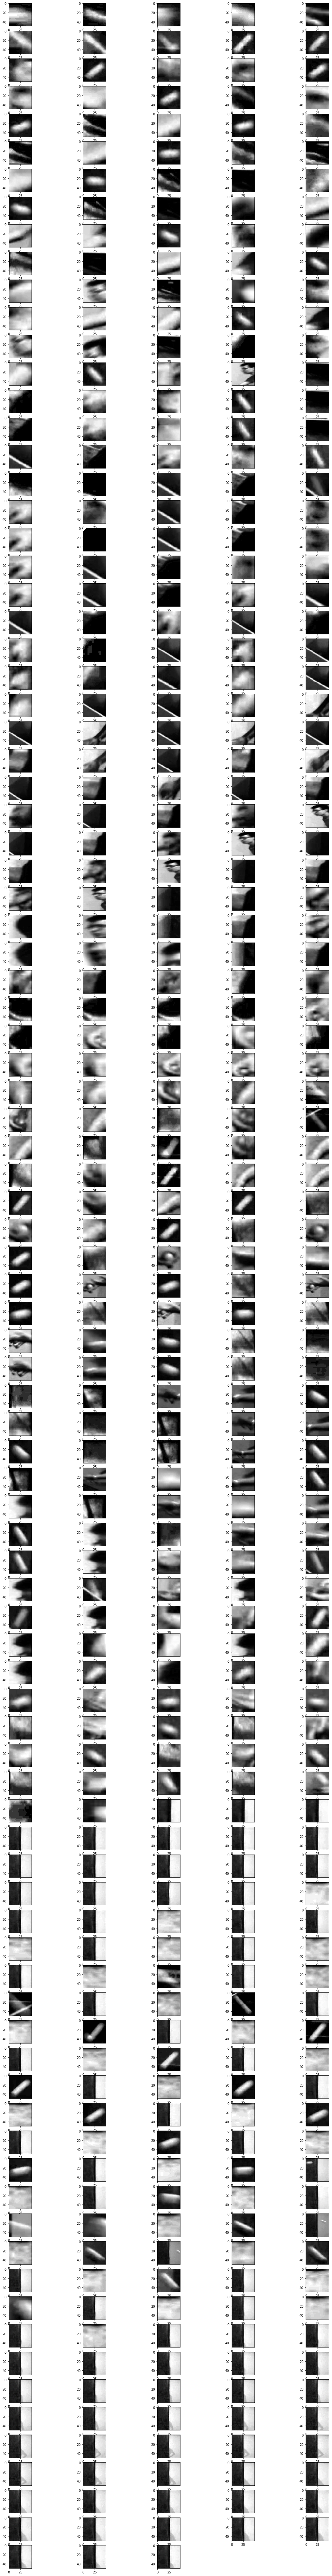

In [19]:
images = []

plt.figure(figsize = (20,150))
fgbg = cv2.createBackgroundSubtractorKNN()

for index in range(1, 464):
    plt.subplot(95, 5, index)
    img = cv2.cvtColor(cv2.imread('Data/Train/video17/frame{}.jpg'.format(index)), cv2.COLOR_BGR2GRAY)
    images.append(cv2.resize(img, (50,50)))
    plt.imshow(images[index - 1], cmap='gray')

# for index in range(1, 89):
#     img = cv2.cvtColor(cv2.imread('Data/frame{}.jpg'.format(index)), cv2.COLOR_RGB2GRAY)
#     images.append(cv2.resize(img, (20,20)))

In [20]:
X = np.concatenate(images, axis=0)

In [21]:
# 1 : 99
y = [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# 100 : 199
y += [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# 200 : 299
y += [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]

# 300 : 463
y += [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


y_test = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1,           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,              1, 1, 1, 1, 1, 1, 1, 1, 1, 0,                0, 0, 0, 0, 0, 0, 0, 1, 0, 1,          1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 
      1, 1, 1, 1, 0, 1, 1, 1, 0, 1,           1, 1, 1, 1, 1, 1, 1, 1, 1, 1,              1, 1, 1, 1, 1, 1, 1, 1, 1, 1,                0, 1, 1, 1, 1, 1, 1, 0]


In [22]:
y = np.array(y)

In [23]:
Y = y.reshape(-1)

In [24]:
X = X.reshape(len(y), -1)

In [25]:
classifier_linear = SVC(kernel='poly')

In [26]:
classifier_linear.fit(X,Y)

/home/ronyell/Documents/ML/virtual/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

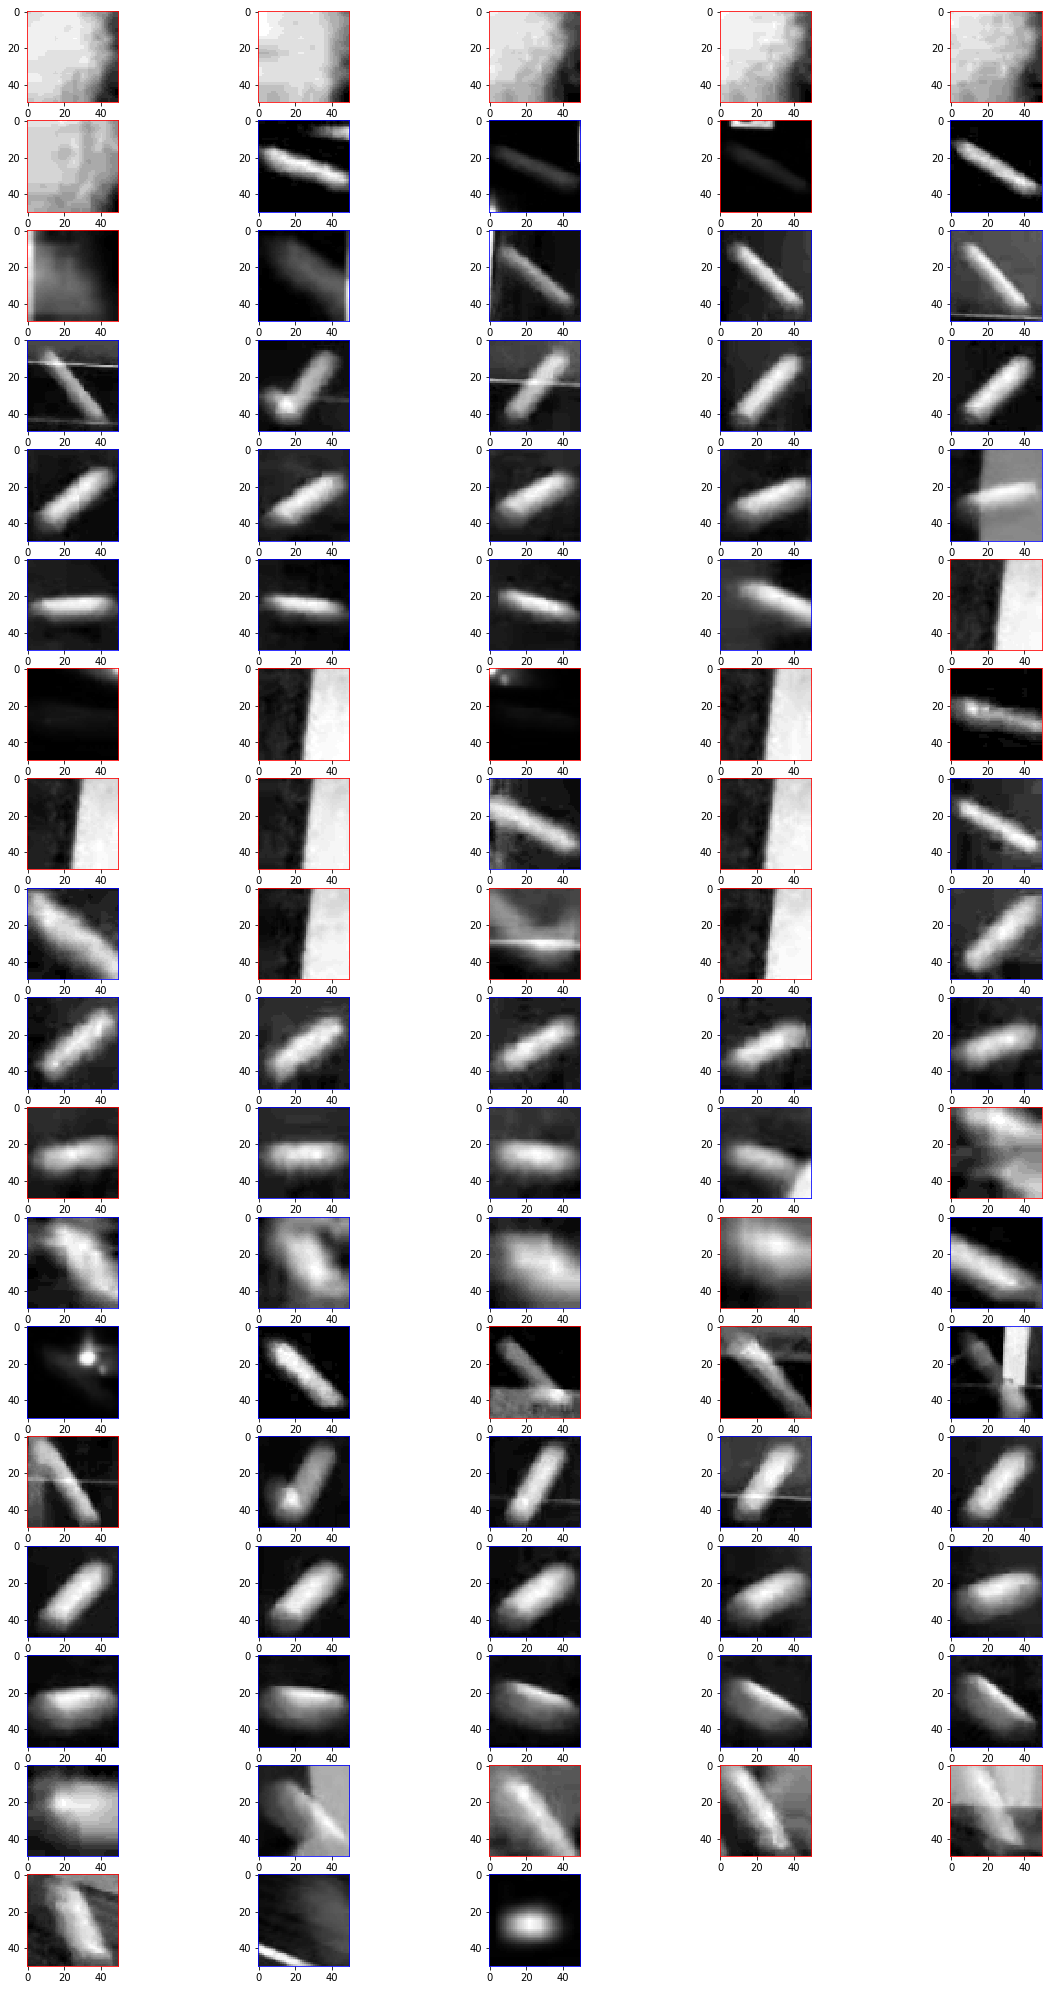

In [27]:
final_images = []
plt.figure(figsize = (20, 40))
font = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16,
    }

predictions = []
for index in range(1, 89):
    ax = plt.subplot(20, 5, index)
    img = cv2.cvtColor(cv2.imread('Data/Train/video18/frame{}.jpg'.format(index)), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50,50))
    final_images.append(img)
    prediction = classifier_linear.predict(img.reshape(1,-1))
    predictions.append(prediction)
    plt.setp(ax.spines.values(), color='red' if prediction.item() == 0 else 'blue')

    plt.imshow(img, cmap='gray')


In [28]:
print(classification_report(y_test, predictions,target_names=['Não Bola','Bola']))

              precision    recall  f1-score   support

    Não Bola       0.63      0.90      0.75        21
        Bola       0.97      0.84      0.90        67

   micro avg       0.85      0.85      0.85        88
   macro avg       0.80      0.87      0.82        88
weighted avg       0.89      0.85      0.86        88



In [506]:
#Video 001
array_candidate = [[399, 299, 0], [399, 299, 1], [399, 299, 2], [476, 353, 2], [528, 353, 2], [399, 299, 3], [358, 348, 3], [449, 7, 45], [491, 21, 46], [541, 44, 47], [597, 78, 48], [646, 112, 49], [714, 177, 50], [685, 139, 50], [733, 192, 51], [725, 269, 86], [666, 295, 87], [595, 329, 88], [520, 367, 89], [467, 414, 90], [457, 379, 90], [409, 348, 91], [362, 319, 92], [314, 292, 93], [267, 270, 94], [219, 250, 95], [171, 235, 96], [122, 223, 97], [73, 215, 98], [36, 211, 99]]
#Video 002
array_candidate = [[399, 299, 0], [399, 299, 1], [133, 253, 2], [123, 324, 2], [133, 252, 3], [725, 313, 3], [649, 290, 3], [15, 360, 29], [51, 347, 30], [13, 322, 30], [117, 328, 31], [18, 308, 31], [182, 314, 32], [23, 291, 32], [25, 276, 33], [245, 305, 33], [26, 270, 34], [307, 300, 34], [26, 274, 35], [365, 300, 35], [24, 285, 36], [422, 304, 36], [20, 299, 37], [477, 312, 37], [14, 317, 38], [530, 324, 38], [585, 341, 39], [635, 359, 40], [689, 386, 41], [730, 410, 42], [778, 412, 43], [795, 400, 44], [726, 277, 74], [672, 283, 75], [594, 296, 76], [515, 312, 77], [438, 333, 78], [358, 360, 79], [278, 391, 80], [197, 427, 81], [135, 398, 82], [74, 369, 83], [28, 347, 84]]
#video 003
array_candidate = [[399, 299, 0], [399, 299, 1], [635, 313, 3], [726, 314, 3], [18, 221, 29], [50, 198, 30], [108, 168, 31], [166, 145, 32], [209,135, 33], [508, 93, 38], [608, 109, 40], [630, 120, 41], [700, 170, 42], [723, 182, 43], [746, 198, 44], [735, 324, 119], [687, 347, 120], [590, 393, 121], [522, 406, 122], [462, 364, 123], [405, 330, 124], [349, 301, 125], [292, 277, 126], [234, 256, 127],[176, 239, 128], [118, 228, 129], [61, 220, 130], [27, 218, 131]]
#video 004
array_candidate = [[399, 299, 0], [399, 299, 1], [399, 299, 2], [621, 327, 2], [728, 316, 2], [45, 298, 29], [110, 289, 30], [185, 285, 31], [256,285, 32], [327, 291, 33], [396, 303, 34], [463, 320, 35], [529, 343, 36], [594, 372, 37], [661, 407, 38], [717, 439, 39], [581, 368, 41], [760, 450, 42], [661, 383, 42], [791, 480, 47], [660, 384, 47], [583, 349, 48], [583, 348, 50], [625, 358, 50], [636, 364, 52]]
#video 005
array_candidate = [[399, 299, 0], [399, 299, 1], [626, 323, 2], [727, 318, 2], [47, 197, 32], [101, 175, 33], [163, 156, 34], [218, 145, 35], [273, 143, 36], [320, 144, 37], [456, 154, 39], [499, 161, 40], [546, 171, 41], [589, 186, 42], [637, 210, 43], [681, 239, 44], [722,269, 45], [744, 293, 46], [740, 323, 68], [718, 305, 69], [690, 288, 70], [662, 275, 71], [635, 265, 72], [609, 259, 73], [583, 257, 74], [560, 258, 75], [536, 261, 76], [514, 268, 77], [493, 277, 78], [473, 288, 79], [453, 302, 80], [435, 318, 81], [413, 378, 82], [417, 337, 82], [404, 356, 83], [225, 348, 97], [215, 344, 98], [203, 340, 99], [194, 340, 100], [185, 340, 101], [182, 340, 102], [182, 341, 103], [182, 344, 104], [184, 350, 105], [184, 355, 106], [188, 361, 107]]
#video 006
array_candidate = [[399, 299, 0], [399, 299, 1], [726, 320, 2], [399, 299, 3], [267, 285, 3], [633, 316, 3], [726, 320, 3], [51, 186, 36], [123, 162, 37], [203, 146, 38], [271, 143, 39], [473, 156, 42], [513, 164, 43], [552, 175, 44], [588, 194, 45], [622, 219, 46], [652, 246, 47], [680, 277, 48], [705, 310, 49], [726, 343, 50], [744, 379, 51], [765, 408, 52], [778, 392, 53], [735, 275, 66], [693, 275, 67], [626, 278, 68], [559, 285, 69], [493, 293, 70], [428, 305, 71], [364, 320, 72], [299, 339, 73], [239, 360, 74], [177, 371,75], [125, 343, 76], [75, 323, 77], [33, 309, 78], [22, 370, 89], [43, 382, 90], [199, 537, 94], [225, 567, 95], [245, 592, 96],[280, 580, 97], [299, 551, 98], [314, 530, 99], [603, 548, 115], [615, 576, 116], [623, 593, 117], [644, 589, 118], [656, 572, 119], [671, 551, 120]]
#video 007
array_candidate = [[399, 299, 0], [399, 299, 1], [727, 327, 2], [728, 318, 3], [23, 255, 34], [91, 237, 35], [210, 216, 36], [313, 205, 37], [404,203, 38], [482, 208, 39], [552, 219, 40], [615, 237, 41], [671, 259, 42], [718, 284, 43], [742, 304, 44], [736, 289, 59], [697, 290, 60], [633, 294, 61], [575, 301, 62], [522, 310, 63], [475, 321, 64], [431, 335, 65], [389, 356, 66], [359, 374, 67], [359, 340, 67], [334, 322, 68], [309, 306, 69], [287, 294, 70], [264, 284, 71], [244, 278, 72], [222, 274, 73], [202, 273, 74], [185, 275, 75], [173, 278, 76], [187, 283, 77], [201, 289, 78], [216, 298, 79], [231, 308, 80], [244, 320, 81], [256, 334, 82], [267, 347, 83], [796, 371, 134], [792, 368, 135], [788, 366, 136], [778, 364, 137], [796, 199, 137]]
#video 008
array_candidate = [[399, 299, 0], [399, 299, 1], [726, 328, 2], [726, 328, 3], [56, 81, 36], [112, 76, 37], [182, 37, 37], [292, 18, 38], [388, 16, 39], [478, 18, 40], [552, 28, 41], [617, 42, 42], [676, 61, 43], [751, 110, 44], [757, 121, 45], [733, 276, 67], [696, 285, 68], [641, 300, 69], [591, 317, 70], [543, 336, 71], [499, 357, 72], [461, 374, 73], [434, 345, 74], [408, 323, 75], [383, 306, 76],[360, 293, 77], [336, 282, 78], [315, 275, 79], [294, 271, 80], [274, 270, 81], [253, 272, 82], [234, 276, 83], [216, 283, 84], [197, 293, 85], [180, 304, 86], [164, 319, 87], [153, 334, 88], [163, 347, 89], [174, 358, 90], [182, 367, 91]]
#video 009
array_candidate = [[399, 299, 0], [399, 299, 1], [713, 348, 2], [733, 323, 2], [728, 329, 3], [37, 287, 36], [103, 256, 37], [192, 221, 38], [267,196, 39], [334, 180, 40], [392, 170, 41], [441, 167, 42], [487, 168, 43], [530, 174, 44], [564, 183, 45], [597, 195, 46], [626, 211, 47], [653, 229, 48], [677, 249, 49], [699, 272, 50], [718, 296, 51], [735, 320, 52], [745, 342, 53], [768, 383, 54], [665, 172, 60], [665, 172, 61], [789, 493, 64], [795, 261, 64], [797, 249, 67], [683, 204, 67], [655, 202, 68], [626, 202, 69], [597, 205, 70], [567, 211, 71], [537, 219, 72], [508, 230, 73], [478, 243, 74], [448, 259, 75], [418, 278, 76], [388, 300, 77], [358, 323, 78], [326, 359, 79], [305, 387, 80], [306, 345, 80], [283, 412, 81], [290, 321, 81], [273, 300, 82], [257, 283, 83], [240, 267,84], [223, 255, 85], [206, 247, 86], [188, 241, 87], [171, 238, 88], [155, 238, 89], [137, 241, 90], [119, 247, 91], [102, 256, 92], [85, 268, 93], [68, 284, 94], [52, 302, 95], [36, 324, 96], [21, 348, 97], [13, 369, 98], [1, 398, 136], [1, 398, 137], [2, 423, 140], [2, 434, 141], [2, 449, 142], [3, 468, 143]]
#video 010
array_candidate = [[399, 299, 0], [399, 299, 1], [735, 329, 2], [713, 364, 3], [733, 322, 3], [36, 72, 35], [71, 70, 36], [156, 33, 36], [202, 23,37], [291, 18, 38], [366, 23, 39], [436, 30, 40], [494, 42, 41], [535, 52, 42], [678, 175, 44], [708, 197, 45], [733, 229, 46], [745, 339, 68], [712, 355, 69], [651, 382, 70], [561, 484, 71], [588, 415, 71], [531, 449, 72], [488, 408, 73], [448, 378, 74], [409, 355, 75], [369, 335, 76], [330, 322, 77], [291, 313, 78], [252, 309, 79], [213, 310, 80], [174, 317, 81], [137, 328, 82], [98, 345, 83], [62, 366, 84], [37, 382, 85], [4, 531, 139], [6, 519, 140]]
#video 011
array_candidate = [[399, 299, 0], [399, 299, 1], [736, 343, 2], [736, 315, 2], [735, 337, 3], [7, 368, 4], [7, 368, 5], [664, 5, 52], [675, 31, 53], [690, 65, 54], [717, 181, 55], [726, 217, 56], [737, 280, 57], [756, 383, 58], [744, 334, 58], [765, 447, 59], [762, 407, 59],[769, 446, 60], [779, 409, 60], [787, 390, 61], [739, 186, 82], [716, 201, 83], [682, 225, 84], [642, 258, 85], [600, 299, 86], [557, 345, 87], [513, 401, 88], [471, 457, 89], [431, 501, 90], [441, 436, 90], [420, 390, 91], [398, 348, 92], [373, 311, 93], [349, 278, 94], [322, 250, 95], [295, 228, 96], [266, 211, 97], [235, 200, 98], [203, 196, 99], [171, 199, 100], [137, 210, 101], [101, 228, 102], [66, 255, 103], [34, 288, 104], [13, 319, 105]]
#video 012
# array_candidate = [[399, 299, 0], [399, 299, 1], [399, 299, 2], [280, 309, 2], [737, 331, 2], [399, 299, 3], [279, 305, 3], [737, 331, 3], [755, 325, 4], [755, 326, 5], [741, 335, 82], [706, 368, 83], [635, 430, 84], [563, 502, 85], [501, 567, 86]]
#video 013
# array_candidate = [[399, 299, 0], [399, 299, 1], [7, 371, 56], [601, 7, 56], [7, 371, 57], [611, 30, 57], [7, 370, 58], [622, 58, 58], [652, 176, 59], [662, 209, 60], [676, 266, 61], [688, 326, 62], [695, 456, 63], [698, 384, 63], [726, 352, 65], [738, 314, 66], [745, 288, 67], [737, 323, 84], [701, 355, 85], [648, 401, 86], [590, 355, 87], [589, 352, 88], [592, 350, 89], [647, 378, 89], [618, 365, 89], [584, 347, 96], [738, 395, 96], [654, 381, 96], [758, 391, 98], [646, 368, 98], [775, 404, 100], [789, 423, 102], [685, 393, 102], [796, 403, 105], [663, 377, 105]]

array_candidate = np.array(array_candidate)

In [507]:
def animate(i):
    data = array_candidate[array_candidate[:, 2] <= i]
    x = data[:,0]
    y = data[:,1]
    z =  data[:,2]
    points.set_data (x, y)
    points.set_3d_properties(z)
    return points, 

<IPython.core.display.Javascript object>


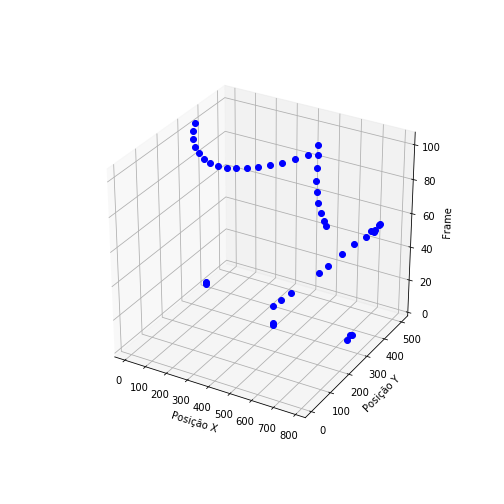

In [508]:
%matplotlib notebook

fig = plt.figure(figsize = (7,7))


ax = fig.add_subplot(1,1,1, projection='3d')

x = array_candidate[:,0]
y = array_candidate[:,1]
z =  array_candidate[:,2]
    
points, = ax.plot(x, y, z, c='b', marker='o', linestyle="")
ax.set_xlabel('Posição X')
ax.set_ylabel('Posição Y')
ax.set_zlabel('Frame')

anim = animation.FuncAnimation(fig, animate, frames=273, interval=20, blit=True)
plt.show()

In [575]:
bounce = start_verification(array_candidate)

In [576]:
print(True if bounce.any() else False)

True


In [577]:
def animate(i):
    data = array_candidate[array_candidate[:, 2] <= i]
    x = data[:,0]
    y = data[:,1]
    z =  data[:,2]
    points.set_data (x, y)
    points.set_3d_properties(z)
    if(bounce.any() and i == bounce[2]):
        bounce_loc, = ax.plot([bounce[0]], [bounce[1]], [bounce[2]], c='r', marker='o', linestyle="")
        
    return points, 

<IPython.core.display.Javascript object>


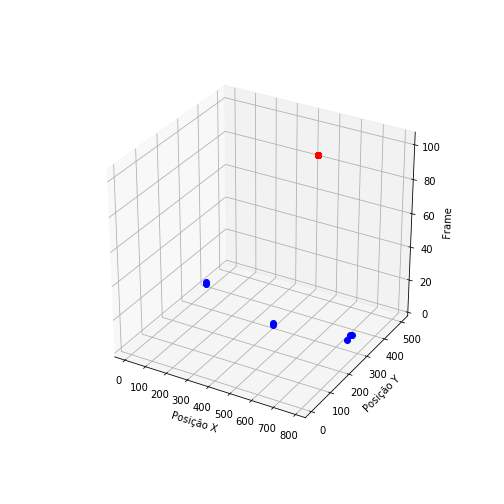

In [578]:
%matplotlib notebook

fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(1,1,1, projection='3d')

x = array_candidate[:,0]
y = array_candidate[:,1]
z = array_candidate[:,2]

points, = ax.plot(x, y, z, c='b', marker='o', linestyle="")

ax.set_xlabel('Posição X')
ax.set_ylabel('Posição Y')
ax.set_zlabel('Frame')

anim = animation.FuncAnimation(fig, animate, frames=288, interval=20, blit=True)
plt.show()